In [1]:
import os
import warnings
import tqdm
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
%load_ext autoreload
%autoreload 2
import socceraction.spadl as spadl
import socceraction.vaep.formula as vaepformula

## Select data

In [3]:
# Configure file and folder names
datafolder = "C:/data-fifa"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder, "predictions.h5")

In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 64


## Compute VAEP values

In [5]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Rating actions"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        spadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left")
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    a = 0.1
    c = 0.1
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(a, c, actions, preds.scores, preds.concedes, preds.recoveries, preds.losts, preds.attacked, preds.attacks)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Rating actions: 100%|██████████| 64/64 [00:03<00:00, 20.32it/s]


Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'player_name', 'nickname', 'team_name', 'scores',
       'concedes', 'recoveries', 'losts', 'attacked', 'attacks',
       'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

## Analyse VAEP ratings
### Most valuable players

In [6]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
160,5503.0,Lionel Messi,5.787014,5.146745,0.640269,873
6,3009.0,Kylian Mbappé,4.841057,4.778162,0.062895,659
422,20750.0,Cody Gakpo,3.828587,3.048856,0.779730,355
535,33018.0,Joško Gvardiol,3.687208,1.814456,1.872753,1030
568,38718.0,Enzo Fernandez,3.346052,1.944686,1.401366,931
436,22084.0,Bukayo Saka,3.269912,2.602619,0.667294,266
212,5675.0,Kalidou Koulibaly,2.906705,1.630418,1.276287,404
158,5487.0,Antoine Griezmann,2.834172,1.951997,0.882175,615
507,29560.0,Julián Álvarez,2.765565,2.925919,-0.160354,294
245,6704.0,Theo Hernández,2.759760,1.756300,1.003460,653


In [7]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5, "player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
296,8361.0,Ritsu Doan,2.661602,2.274919,0.386683,150,235,1.019337,0.871245,0.148091
134,5235.0,Ramin Rezaeian,2.355027,1.572379,0.782648,213,212,0.999776,0.667519,0.332256
436,22084.0,Bukayo Saka,3.269912,2.602619,0.667294,266,311,0.946277,0.753169,0.193108
399,16527.0,Mislav Oršić,1.942616,1.794389,0.148228,137,193,0.905883,0.836761,0.069122
270,7426.0,Jean-Charles Castelletto,1.775451,1.126047,0.649404,173,201,0.794978,0.504200,0.290778
668,139016.0,Achraf Dari,1.621873,1.146057,0.475816,214,204,0.715532,0.505613,0.209919
422,20750.0,Cody Gakpo,3.828587,3.048856,0.779730,355,484,0.711927,0.566936,0.144991
404,17033.0,Mohammed Kudus,2.009330,1.654475,0.354855,226,268,0.674775,0.555607,0.119168
277,7796.0,Silvan Widmer,2.135282,0.978449,1.156833,313,286,0.671942,0.307904,0.364038
160,5503.0,Lionel Messi,5.787014,5.146745,0.640269,873,786,0.662635,0.589322,0.073313


In [8]:
# Compute each player's number of actions and total offensive values
playersR.sort_values("offensive_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
160,5503.0,Lionel Messi,5.787014,5.146745,0.640269,873
6,3009.0,Kylian Mbappé,4.841057,4.778162,0.062895,659
422,20750.0,Cody Gakpo,3.828587,3.048856,0.779730,355
507,29560.0,Julián Álvarez,2.765565,2.925919,-0.160354,294
436,22084.0,Bukayo Saka,3.269912,2.602619,0.667294,266
296,8361.0,Ritsu Doan,2.661602,2.274919,0.386683,150
40,3318.0,Marcus Rashford,2.226896,2.049646,0.177250,173
32,3280.0,Richarlison,1.984868,1.992683,-0.007814,170
570,38803.0,Gonçalo Ramos,2.089559,1.991839,0.097720,85
158,5487.0,Antoine Griezmann,2.834172,1.951997,0.882175,615


In [9]:
# Compute each player's number of actions and total defensive values
playersR.sort_values("defensive_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
535,33018.0,Joško Gvardiol,3.687208,1.814456,1.872753,1030
138,5245.0,Achraf Hakimi,2.539689,0.937197,1.602492,760
568,38718.0,Enzo Fernandez,3.346052,1.944686,1.401366,931
35,3295.0,Thiago Silva,2.181818,0.886075,1.295743,644
212,5675.0,Kalidou Koulibaly,2.906705,1.630418,1.276287,404
353,12034.0,David Raum,1.674913,0.423848,1.251065,350
300,8519.0,Dayotchanculle Upamecano,2.219717,0.978762,1.240956,689
505,29201.0,Nahuel Molina,2.624622,1.429194,1.195428,647
51,3471.0,Dejan Lovren,1.816821,0.631963,1.184858,889
41,3336.0,Harry Maguire,1.936417,0.760282,1.176136,796


In [10]:
with open("players_with_value.json", "r", encoding="utf-8") as file:
    data = json.load(file)

df = pd.DataFrame([(team, player["player_name"], player["position"], player["value"]) 
                   for team, players in data.items() 
                   for player in players],
                  columns=["team", "player_name", "position", "value"])

playersRR = playersR.merge(df)

playersRR

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team,position,value
0,2941.0,Ismaïla Sarr,0.856727,0.251014,0.605712,233,Senegal,RW,22000000
1,2954.0,Youri Tielemans,0.510475,0.114872,0.395603,118,Belgium,CM,40000000
2,2972.0,Marcus Thuram,0.277492,-0.033523,0.311015,127,France,CF,30000000
3,2988.0,Memphis Depay,0.226053,0.067387,0.158665,281,Netherlands,CF,20000000
4,2989.0,Alexander Djiku,0.233966,-0.025549,0.259515,65,Ghana,CB,8000000
...,...,...,...,...,...,...,...,...,...
625,149714.0,Abde Ezzalzouli,0.321026,0.066387,0.254639,57,Morocco,LW,8000000
626,184468.0,Alvaro José Zamora Mata,0.029797,-0.016760,0.046557,14,Costa Rica,LW,200000
627,227697.0,Garang Kuol,0.028198,-0.102660,0.130859,19,Australia,LW,800000
628,296254.0,Walid Cheddira,-0.124096,-0.204849,0.080754,33,Morocco,CF,2500000


In [11]:
correlation_coefficient, _ = pearsonr(playersRR['vaep_value'], playersRR['value'])
print(f'ピアソン相関係数: {correlation_coefficient}')

spearman_corr = playersRR[['vaep_value', 'value']].corr(method='spearman').iloc[0, 1]
print(f"スピアマンの順位相関係数: {spearman_corr}")

ピアソン相関係数: 0.3140161206347897
スピアマンの順位相関係数: 0.24581685101940673


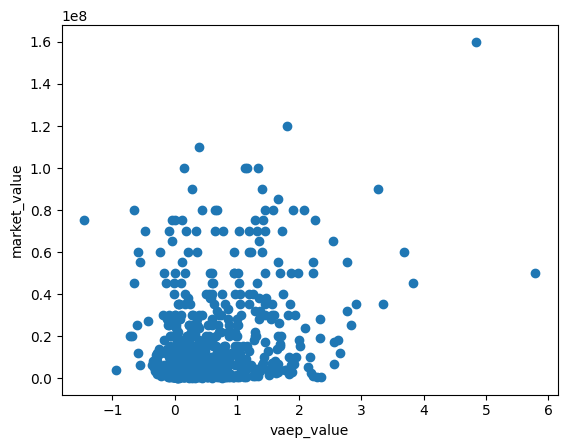

In [12]:
plt.scatter(playersRR['vaep_value'], playersRR['value'])
plt.xlabel('vaep_value')
plt.ylabel('market_value')
plt.show()

In [13]:
cf = playersRR[(playersRR['position'] == 'CF') | (playersRR['position'] == 'SS')]
sorted_cf = cf.sort_values('vaep_value', ascending=False)[:10]
sorted_cf

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team,position,value
388,20750.0,Cody Gakpo,3.828587,3.048856,0.779730,355,Netherlands,CF,45000000
146,5487.0,Antoine Griezmann,2.834172,1.951997,0.882175,615,France,CF,25000000
470,29560.0,Julián Álvarez,2.765565,2.925919,-0.160354,294,Argentina,CF,32000000
529,38803.0,Gonçalo Ramos,2.089559,1.991839,0.097720,85,Portugal,CF,24000000
29,3280.0,Richarlison,1.984868,1.992683,-0.007814,170,Brazil,CF,50000000
59,3604.0,Olivier Giroud,1.793751,1.583650,0.210101,152,France,CF,4000000
458,28559.0,Enner Valencia,1.663314,1.525745,0.137569,167,Ecuador,CF,3000000
256,7829.0,Wout Weghorst,1.644915,1.689209,-0.044294,38,Netherlands,CF,14000000
312,11174.0,Vincent Aboubakar,1.644477,1.732823,-0.088346,93,Cameroon,CF,5000000
482,30628.0,Daizen Maeda,1.122323,0.811166,0.311156,39,Japan,CF,4000000


In [14]:
correlation_coefficient, _ = pearsonr(cf['vaep_value'], cf['value'])
print(f'ピアソン相関係数: {correlation_coefficient}')

spearman_corr = cf[['vaep_value', 'value']].corr(method='spearman').iloc[0, 1]
print(f"スピアマンの順位相関係数: {spearman_corr}")

ピアソン相関係数: 0.09996533190447
スピアマンの順位相関係数: 0.11793875459453076


c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\3981305105.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cf['cluster'] = kmeans.fit_predict(features_scaled)
c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X,

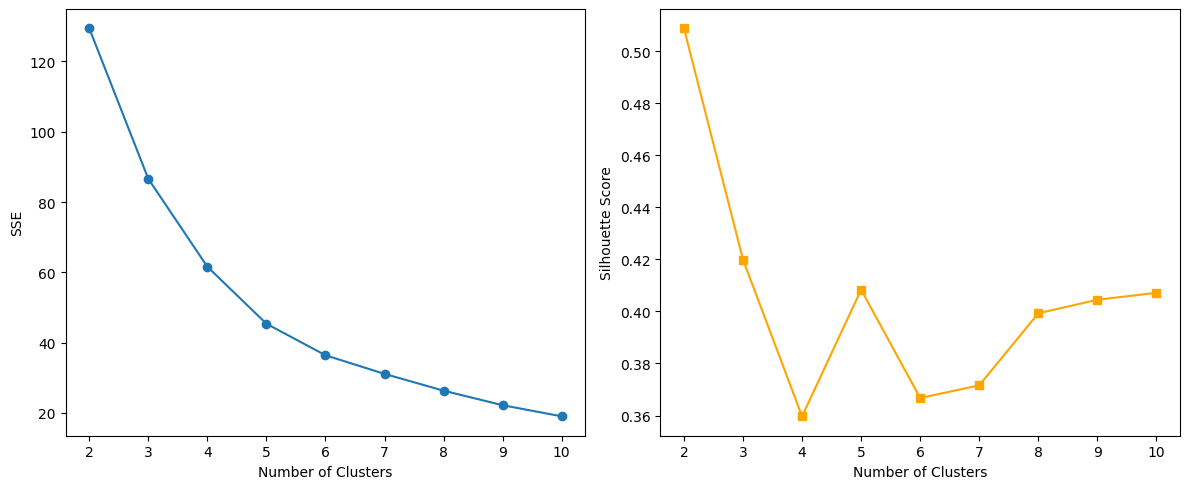

c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\3981305105.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cf['cluster'] = kmeans.fit_predict(features_scaled)


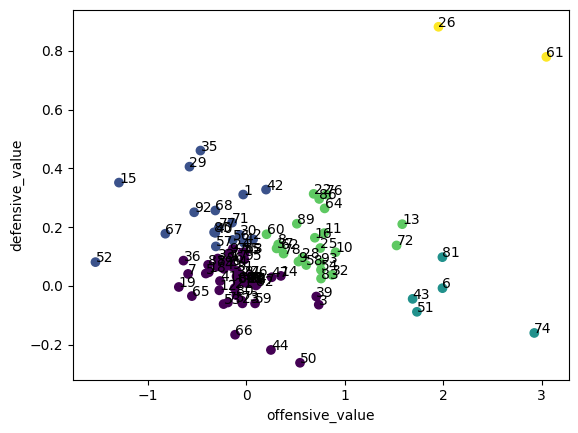

\begin{tabular}{rl}
\toprule
 Player Number &                       Player Name \\
\midrule
             1 &                     Marcus Thuram \\
             2 &                     Memphis Depay \\
             3 &                      Wahbi Khazri \\
             4 &                     Gabriel Jesus \\
             5 &                   Vincent Janssen \\
             6 &                       Richarlison \\
             7 &                     Romelu Lukaku \\
             8 &                       Jordan Ayew \\
             9 &                   Michy Batshuayi \\
            10 &                     Álvaro Morata \\
            11 &          Eric Maxim Choupo-Moting \\
            12 &                  Karl Toko Ekambi \\
            13 &                    Olivier Giroud \\
            14 &                     Callum Wilson \\
            15 &                     Kieffer Moore \\
            16 &               Aleksandar Mitrović \\
            17 &                    Edinson 

C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\3981305105.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table_cf.to_latex(index=False)


In [15]:
features = cf[['offensive_value', 'defensive_value']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

cluster_range = range(2,11)
sse_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cf['cluster'] = kmeans.fit_predict(features_scaled)

    sse = kmeans.inertia_
    sse_values.append(sse)

    silhouette_avg = silhouette_score(features_scaled, cf['cluster'])
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='s', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cf['cluster'] = kmeans.fit_predict(features_scaled)

plt.scatter(cf['offensive_value'], cf['defensive_value'], c=cf['cluster'], cmap='viridis')
plt.xlabel('offensive_value')
plt.ylabel('defensive_value')

for i, txt in enumerate(range(len(cf))):
    plt.annotate(i+1, (cf['offensive_value'].iloc[i], cf['defensive_value'].iloc[i]))

plt.show()

table_data = {'Player Number': list(range(1, len(cf) + 1)),
              'Player Name': cf['player_name']}
table_cf = pd.DataFrame(table_data)
latex_table = table_cf.to_latex(index=False)
print(latex_table)

In [16]:
rw = playersRR[(playersRR['position'] == 'RW') | (playersRR['position'] == 'RM')]
sorted_rw = rw.sort_values('vaep_value', ascending=False)[:10]
sorted_rw

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team,position,value
148,5503.0,Lionel Messi,5.787014,5.146745,0.640269,873,Argentina,RW,50000000
401,22084.0,Bukayo Saka,3.269912,2.602619,0.667294,266,England,RW,90000000
270,8361.0,Ritsu Doan,2.661602,2.274919,0.386683,150,Japan,RW,12000000
124,5237.0,Hakim Ziyech,2.565248,1.693924,0.871324,688,Morocco,RW,17000000
263,8125.0,Denzel Dumfries,2.337789,1.425306,0.912483,437,Netherlands,RM,28000000
5,2995.0,Ángel Di María,1.835433,1.447412,0.388022,400,Argentina,RW,10000000
55,3533.0,Xherdan Shaqiri,1.601824,1.438989,0.162836,217,Switzerland,RW,4000000
305,10595.0,Raphinha,1.443029,0.881056,0.561972,345,Brazil,RW,50000000
163,5571.0,Hirving Lozano,1.359036,1.065296,0.293739,215,Mexico,RW,28000000
271,8400.0,Serge Gnabry,1.356345,0.794859,0.561486,255,Germany,RW,65000000


In [17]:
correlation_coefficient, _ = pearsonr(rw['vaep_value'], rw['value'])
print(f'ピアソン相関係数: {correlation_coefficient}')

spearman_corr = rw[['vaep_value', 'value']].corr(method='spearman').iloc[0, 1]
print(f"スピアマンの順位相関係数: {spearman_corr}")

ピアソン相関係数: 0.3461774284274669
スピアマンの順位相関係数: 0.2401318909004045


c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\664558565.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rw['cluster'] = kmeans.fit_predict(features_scaled)
c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, 

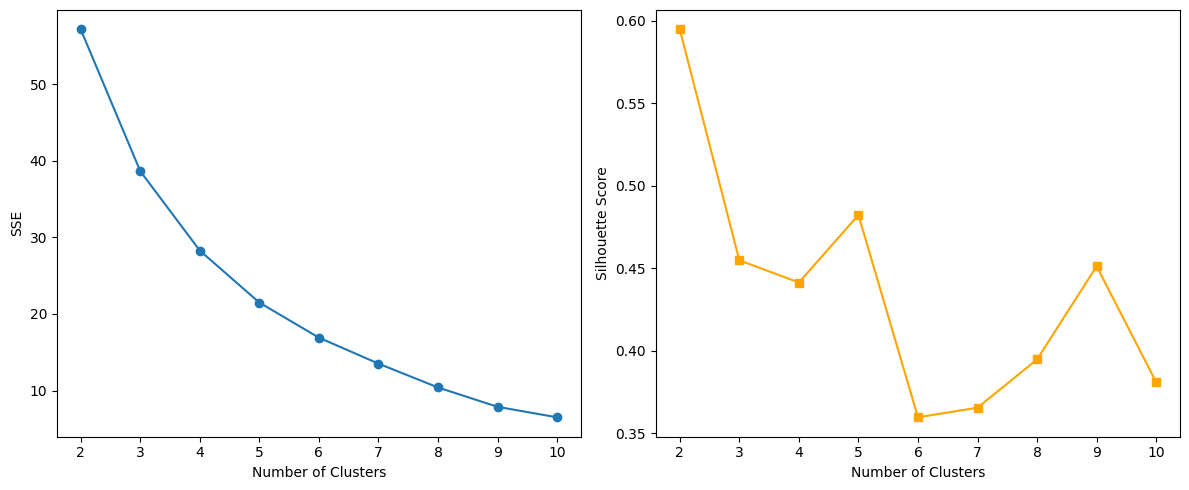

c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\664558565.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rw['cluster'] = kmeans.fit_predict(features_scaled)


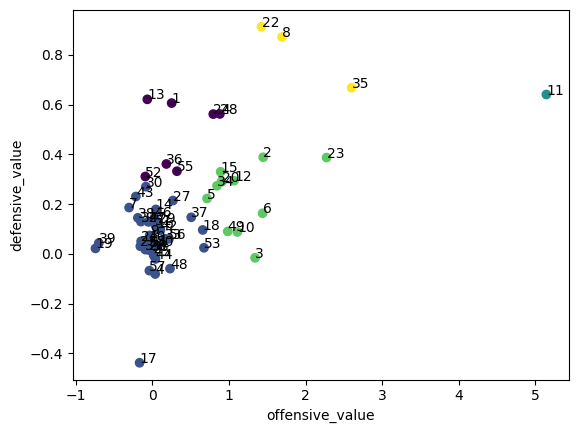

\begin{tabular}{rl}
\toprule
 Player Number &             Player Name \\
\midrule
             1 &            Ismaïla Sarr \\
             2 &          Ángel Di María \\
             3 &              Leroy Sané \\
             4 &         Kwon Chang-Hoon \\
             5 &            Timothy Weah \\
             6 &         Xherdan Shaqiri \\
             7 &            Bryan Mbeumo \\
             8 &            Hakim Ziyech \\
             9 &     Alireza Jahanbakhsh \\
            10 &         Ousmane Dembélé \\
            11 &            Lionel Messi \\
            12 &          Hirving Lozano \\
            13 &           Joel Campbell \\
            14 & Marco Asensio Willemsen \\
            15 &        Andrija Živković \\
            16 &            Ángel Correa \\
            17 &          Iñaki Williams \\
            18 &             Gareth Bale \\
            19 &           Pablo Sarabia \\
            20 &           Ferrán Torres \\
            21 &   Przemysław Frankows

C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\664558565.py:52: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table_rw.to_latex(index=False)


In [18]:
features = rw[['offensive_value', 'defensive_value']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

cluster_range = range(2,11)
sse_values = []
silhouette_scores = []
calinski_harabasz_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    rw['cluster'] = kmeans.fit_predict(features_scaled)

    sse = kmeans.inertia_
    sse_values.append(sse)

    silhouette_avg = silhouette_score(features_scaled, rw['cluster'])
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='s', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
rw['cluster'] = kmeans.fit_predict(features_scaled)

plt.scatter(rw['offensive_value'], rw['defensive_value'], c=rw['cluster'], cmap='viridis')
plt.xlabel('offensive_value')
plt.ylabel('defensive_value')

for i, txt in enumerate(range(len(rw))):
    plt.annotate(i+1, (rw['offensive_value'].iloc[i], rw['defensive_value'].iloc[i]))

plt.show()

table_data = {'Player Number': list(range(1, len(rw) + 1)),
              'Player Name': rw['player_name']}
table_rw = pd.DataFrame(table_data)
latex_table = table_rw.to_latex(index=False)
print(latex_table)

In [19]:
lw = playersRR[(playersRR['position'] == 'LW') | (playersRR['position'] == 'LM')]
sorted_lw = lw.sort_values('vaep_value', ascending=False)[:10]
sorted_lw

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team,position,value
6,3009.0,Kylian Mbappé,4.841057,4.778162,0.062895,659,France,LW,160000000
37,3318.0,Marcus Rashford,2.226896,2.049646,0.177250,173,England,LW,55000000
368,16527.0,Mislav Oršić,1.942616,1.794389,0.148228,137,Croatia,LW,10000000
102,5187.0,Salem Al Dawsari,1.839341,1.626579,0.212762,270,Saudi Arabia,LW,1800000
379,18395.0,Vinícius Júnior,1.797019,1.653779,0.143239,267,Brazil,LW,120000000
378,18360.0,Rafael Leão,1.652777,1.640403,0.012374,126,Portugal,LW,85000000
269,8346.0,Craig Goodwin,1.521966,1.064107,0.457859,176,Australia,LW,1200000
83,4320.0,Neymar,1.420269,1.357247,0.063022,379,Brazil,LW,75000000
143,5481.0,Mathew Leckie,1.290050,0.759837,0.530212,252,Australia,LW,800000
296,9638.0,Jack Grealish,1.025739,0.859228,0.166511,125,England,LW,70000000


In [20]:
correlation_coefficient, _ = pearsonr(lw['vaep_value'], lw['value'])
print(f'ピアソン相関係数: {correlation_coefficient}')

spearman_corr = lw[['vaep_value', 'value']].corr(method='spearman').iloc[0, 1]
print(f"スピアマンの順位相関係数: {spearman_corr}")

ピアソン相関係数: 0.5708197923486081
スピアマンの順位相関係数: 0.2573432824853687


c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\1373669587.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lw['cluster'] = kmeans.fit_predict(features_scaled)
c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X,

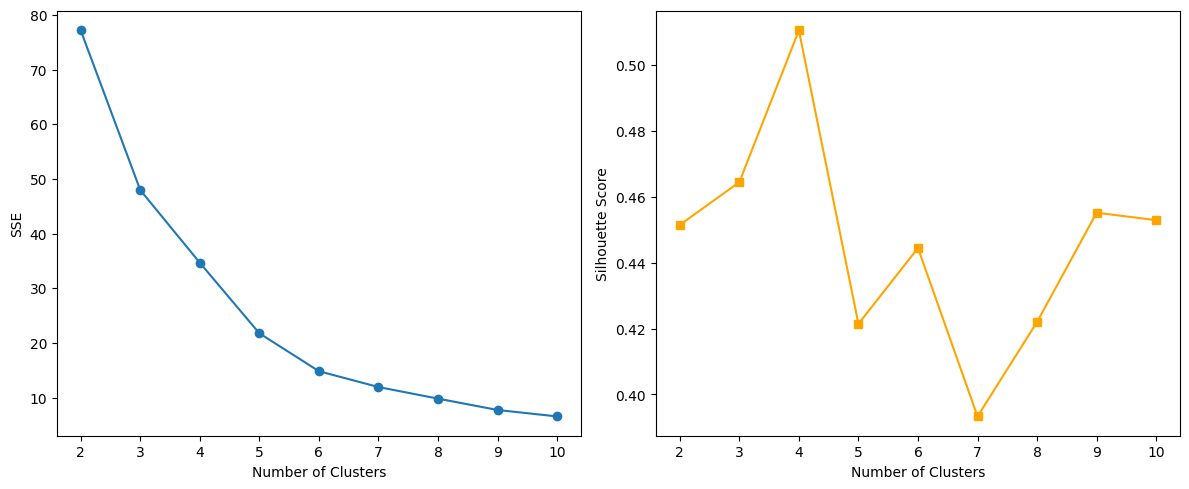

c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\1373669587.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lw['cluster'] = kmeans.fit_predict(features_scaled)


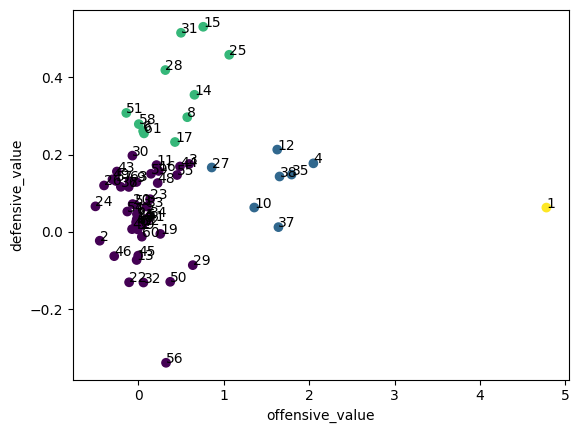

\begin{tabular}{rl}
\toprule
 Player Number &             Player Name \\
\midrule
             1 &           Kylian Mbappé \\
             2 &           Son Heung-Min \\
             3 &         Raheem Sterling \\
             4 &         Marcus Rashford \\
             5 &              André Ayew \\
             6 &              Naïm Sliti \\
             7 &             Eden Hazard \\
             8 &          Sofiane Boufal \\
             9 &  Georges-Kevin N'Koudou \\
            10 &                  Neymar \\
            11 &            Philip Foden \\
            12 &        Salem Al Dawsari \\
            13 &           Hattan Babhir \\
            14 &            Ivan Perišić \\
            15 &           Mathew Leckie \\
            16 &            Filip Kostić \\
            17 &          Thorgan Hazard \\
            18 &        Yannick Carrasco \\
            19 &        Nemanja Radonjić \\
            20 &              Papu Gómez \\
            21 &           Darko Lazov

C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\1373669587.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table_lw.to_latex(index=False)


In [21]:
features = lw[['offensive_value', 'defensive_value']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

cluster_range = range(2,11)
sse_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    lw['cluster'] = kmeans.fit_predict(features_scaled)

    sse = kmeans.inertia_
    sse_values.append(sse)

    silhouette_avg = silhouette_score(features_scaled, lw['cluster'])
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='s', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
lw['cluster'] = kmeans.fit_predict(features_scaled)

plt.scatter(lw['offensive_value'], lw['defensive_value'], c=lw['cluster'], cmap='viridis')
plt.xlabel('offensive_value')
plt.ylabel('defensive_value')

for i, txt in enumerate(range(len(lw))):
    plt.annotate(i+1, (lw['offensive_value'].iloc[i], lw['defensive_value'].iloc[i]))

plt.show()

table_data = {'Player Number': list(range(1, len(lw) + 1)),
              'Player Name': lw['player_name']}
table_lw = pd.DataFrame(table_data)
latex_table = table_lw.to_latex(index=False)
print(latex_table)

In [22]:
am = playersRR[playersRR['position'] == 'AM']
sorted_am = am.sort_values('vaep_value', ascending=False)[:10]
sorted_am

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team,position,value
131,5258.0,Giorgian De Arrascaeta,2.340056,1.783628,0.556428,104,Uruguay,AM,19000000
107,5204.0,Bruno Fernandes,2.254525,1.772562,0.481963,454,Portugal,AM,75000000
372,17033.0,Mohammed Kudus,2.009330,1.654475,0.354855,226,Ghana,AM,15000000
289,8966.0,Kai Havertz,1.718593,1.620611,0.097982,75,Germany,AM,70000000
15,3089.0,Kevin De Bruyne,1.450923,1.234036,0.216887,283,Belgium,AM,80000000
73,3831.0,Dušan Tadić,1.076111,0.498692,0.577420,275,Serbia,AM,7000000
407,22600.0,Lucas Paquetá,1.028387,0.827887,0.200499,386,Brazil,AM,45000000
369,16532.0,Daniel Olmo,0.976181,0.220836,0.755345,457,Spain,AM,40000000
314,11184.0,Otavinho,0.719469,0.367421,0.352048,264,Portugal,AM,30000000
463,28914.0,Lovro Majer,0.716048,0.638117,0.077931,223,Croatia,AM,22000000


In [23]:
correlation_coefficient, _ = pearsonr(am['vaep_value'], am['value'])
print(f'ピアソン相関係数: {correlation_coefficient}')

spearman_corr = am[['vaep_value', 'value']].corr(method='spearman').iloc[0, 1]
print(f"スピアマンの順位相関係数: {spearman_corr}")

ピアソン相関係数: 0.36458881966880025
スピアマンの順位相関係数: 0.3585462713193882


c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\115114039.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am['cluster'] = kmeans.fit_predict(features_scaled)
c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, 

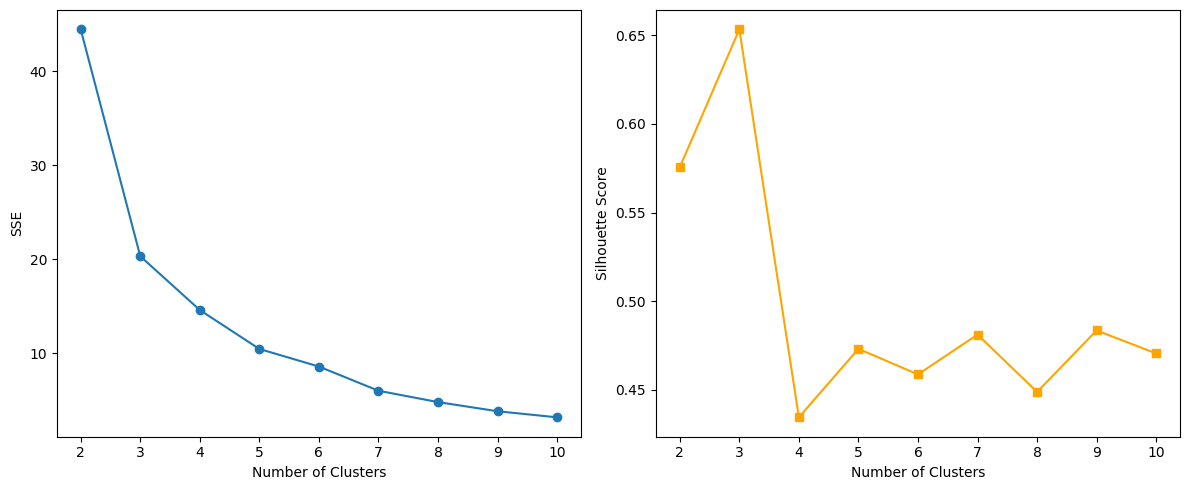

c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\115114039.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am['cluster'] = kmeans.fit_predict(features_scaled)


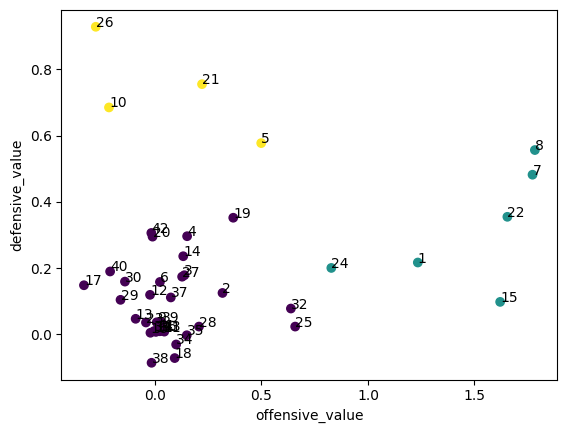

\begin{tabular}{rl}
\toprule
 Player Number &             Player Name \\
\midrule
             1 &         Kevin De Bruyne \\
             2 &          Bernardo Silva \\
             3 &           Nikola Vlašić \\
             4 &       Abdelhamid Sabiri \\
             5 &             Dušan Tadić \\
             6 &     Sebastian Szymański \\
             7 &         Bruno Fernandes \\
             8 &  Giorgian De Arrascaeta \\
             9 &              Bryan Ruiz \\
            10 &            Lee Jae-Sung \\
            11 &          Filip Djuricic \\
            12 &         Steven Berghuis \\
            13 &             Mason Mount \\
            14 &             Mario Götze \\
            15 &             Kai Havertz \\
            16 &       David Wotherspoon \\
            17 &           Daichi Kamada \\
            18 &          Olivier Ntcham \\
            19 &                Otavinho \\
            20 &           Mario Pašalić \\
            21 &             Daniel Ol

C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\115114039.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table_am.to_latex(index=False)


In [24]:
features = am[['offensive_value', 'defensive_value']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

cluster_range = range(2,11)
sse_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    am['cluster'] = kmeans.fit_predict(features_scaled)

    sse = kmeans.inertia_
    sse_values.append(sse)

    silhouette_avg = silhouette_score(features_scaled, am['cluster'])
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='s', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
am['cluster'] = kmeans.fit_predict(features_scaled)

plt.scatter(am['offensive_value'], am['defensive_value'], c=am['cluster'], cmap='viridis')
plt.xlabel('offensive_value')
plt.ylabel('defensive_value')

for i, txt in enumerate(range(len(am))):
    plt.annotate(i+1, (am['offensive_value'].iloc[i], am['defensive_value'].iloc[i]))

plt.show()

table_data = {'Player Number': list(range(1, len(am) + 1)),
              'Player Name': am['player_name']}
table_am = pd.DataFrame(table_data)
latex_table = table_am.to_latex(index=False)
print(latex_table)

In [25]:
cm = playersRR[playersRR['position'] == 'CM']
sorted_cm = cm.sort_values('vaep_value', ascending=False)[:10]
sorted_cm

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team,position,value
527,38718.0,Enzo Fernandez,3.346052,1.944686,1.401366,931,Argentina,CM,35000000
137,5463.0,Luka Modrić,2.173576,1.337267,0.836309,1105,Croatia,CM,10000000
262,8118.0,Frenkie de Jong,1.865204,1.043810,0.821394,692,Netherlands,CM,50000000
189,5660.0,Piotr Zieliński,1.737522,1.230310,0.507211,280,Poland,CM,40000000
54,3532.0,Jordan Henderson,1.691626,1.498287,0.193339,320,England,CM,15000000
255,7797.0,Rodrigo De Paul,1.562941,0.421274,1.141667,1106,Argentina,CM,35000000
235,6983.0,Remo Freuler,1.503837,0.926997,0.576840,310,Switzerland,CM,13000000
619,133353.0,Gavi,1.398986,0.933303,0.465682,339,Spain,CM,90000000
551,46258.0,Azzedine Ounahi,1.378444,0.449352,0.929091,590,Morocco,CM,3500000
229,6773.0,Federico Valverde,1.331251,0.622157,0.709094,357,Uruguay,CM,100000000


In [26]:
correlation_coefficient, _ = pearsonr(cm['vaep_value'], cm['value'])
print(f'ピアソン相関係数: {correlation_coefficient}')

spearman_corr = cm[['vaep_value', 'value']].corr(method='spearman').iloc[0, 1]
print(f"スピアマンの順位相関係数: {spearman_corr}")

ピアソン相関係数: 0.41663414520595
スピアマンの順位相関係数: 0.3519288180017739


c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\631937698.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cm['cluster'] = kmeans.fit_predict(features_scaled)
c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, 

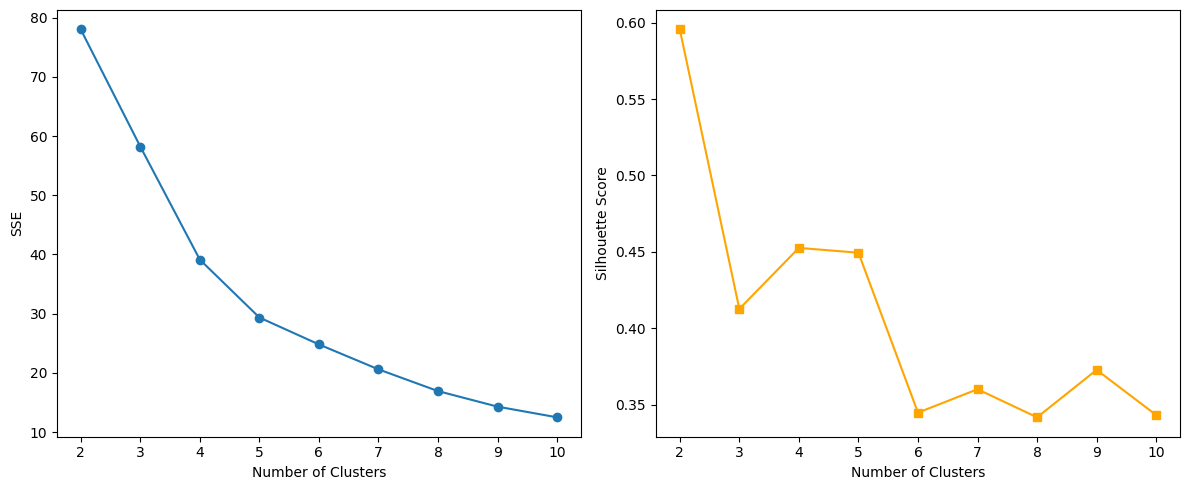

c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\631937698.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cm['cluster'] = kmeans.fit_predict(features_scaled)


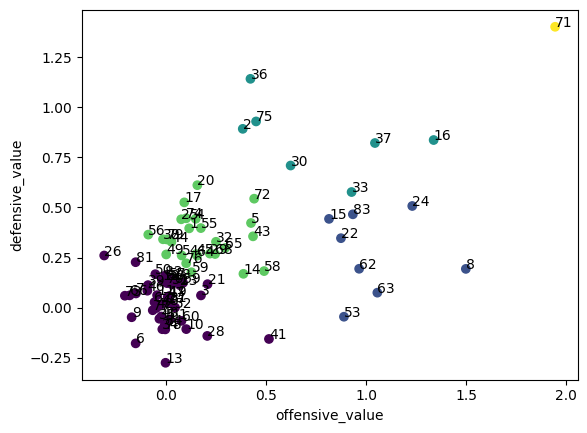

\begin{tabular}{rl}
\toprule
 Player Number &                Player Name \\
\midrule
             1 &            Youri Tielemans \\
             2 &              Adrien Rabiot \\
             3 &          Christian Eriksen \\
             4 &       André Zambo Anguissa \\
             5 &                 Aaron Mooy \\
             6 &              Idrissa Gueye \\
             7 &               Aaron Ramsey \\
             8 &           Jordan Henderson \\
             9 &                 João Mário \\
            10 &              Davy Klaassen \\
            11 &            Salman Al Faraj \\
            12 &                       Koke \\
            13 &              Matías Vecino \\
            14 &          Rodrigo Bentancur \\
            15 &              Mateo Kovačić \\
            16 &                Luka Modrić \\
            17 &             Jackson Irvine \\
            18 &             Thomas Delaney \\
            19 &            Andrés Guardado \\
            20 &      

C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\631937698.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table_cm.to_latex(index=False)


In [27]:
features = cm[['offensive_value', 'defensive_value']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

cluster_range = range(2,11)
sse_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cm['cluster'] = kmeans.fit_predict(features_scaled)

    sse = kmeans.inertia_
    sse_values.append(sse)

    silhouette_avg = silhouette_score(features_scaled, cm['cluster'])
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='s', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cm['cluster'] = kmeans.fit_predict(features_scaled)

plt.scatter(cm['offensive_value'], cm['defensive_value'], c=cm['cluster'], cmap='viridis')
plt.xlabel('offensive_value')
plt.ylabel('defensive_value')

for i, txt in enumerate(range(len(cm))):
    plt.annotate(i+1, (cm['offensive_value'].iloc[i], cm['defensive_value'].iloc[i]))

plt.show()

table_data = {'Player Number': list(range(1, len(cm) + 1)),
              'Player Name': cm['player_name']}
table_cm = pd.DataFrame(table_data)
latex_table = table_cm.to_latex(index=False)
print(latex_table)

In [28]:
dm = playersRR[playersRR['position'] == 'DM']
sorted_dm = dm.sort_values('vaep_value', ascending=False)[:10]
sorted_dm

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team,position,value
228,6765.0,Rodri,2.071751,1.438713,0.633037,1286,Spain,DM,80000000
303,10481.0,Aurélien Tchouaméni,1.902004,1.486167,0.415837,946,France,DM,80000000
154,5539.0,Casemiro,1.689598,1.140725,0.548873,488,Brazil,DM,50000000
462,28825.0,Luis Chávez,1.659020,1.330756,0.328263,284,Mexico,DM,6500000
167,5579.0,Joshua Kimmich,1.574785,1.117469,0.457316,494,Germany,DM,80000000
522,37726.0,Moisés Caicedo,1.474682,1.105307,0.369375,292,Ecuador,DM,38000000
138,5469.0,Marcelo Brozović,1.457240,0.480556,0.976684,1053,Croatia,DM,35000000
338,12751.0,Tyler Adams,1.445793,0.652042,0.793752,514,United States,DM,17000000
363,16308.0,Leandro Paredes,1.154864,0.923258,0.231606,472,Argentina,DM,15000000
98,4934.0,Ethan Ampadu,1.142904,0.351311,0.791593,281,Wales,DM,9000000


In [29]:
correlation_coefficient, _ = pearsonr(dm['vaep_value'], dm['value'])
print(f'ピアソン相関係数: {correlation_coefficient}')

spearman_corr = dm[['vaep_value', 'value']].corr(method='spearman').iloc[0, 1]
print(f"スピアマンの順位相関係数: {spearman_corr}")

ピアソン相関係数: 0.43714757010463806
スピアマンの順位相関係数: 0.3345435872314601


c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\2948656139.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm['cluster'] = kmeans.fit_predict(features_scaled)
c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X,

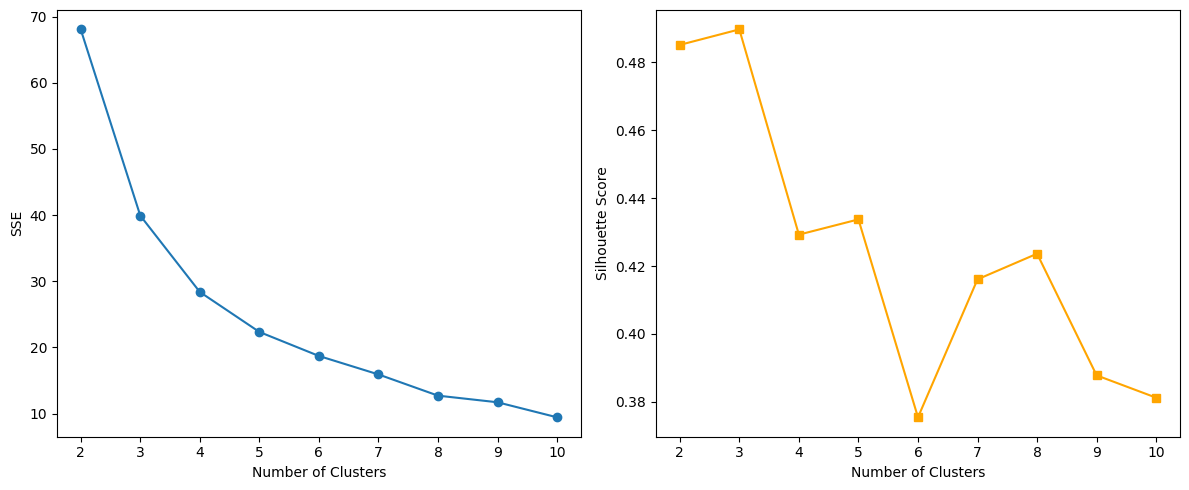

c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\2948656139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dm['cluster'] = kmeans.fit_predict(features_scaled)


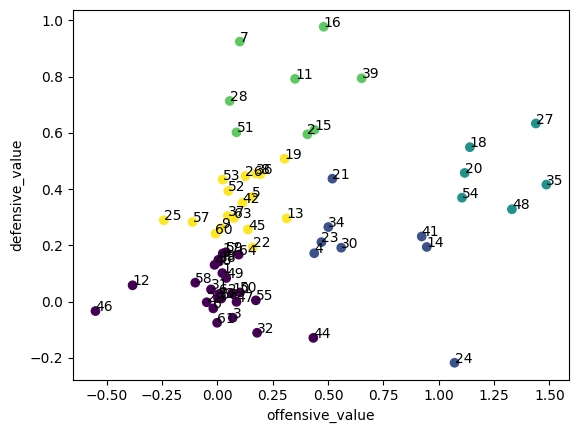

\begin{tabular}{rl}
\toprule
 Player Number &                Player Name \\
\midrule
             1 &                    Fabinho \\
             2 &               Granit Xhaka \\
             3 &               Marko Grujić \\
             4 &      Pierre-Emile Højbjerg \\
             5 &        Grzegorz Krychowiak \\
             6 &           Cheikhou Kouyaté \\
             7 &        Ellyes Joris Skhiri \\
             8 &                Declan Rice \\
             9 &             Nampalys Mendy \\
            10 &            Kalvin Phillips \\
            11 &               Ethan Ampadu \\
            12 &            Sergio Busquets \\
            13 &           William Carvalho \\
            14 &            Roozbeh Cheshmi \\
            15 &             Sofyan Amrabat \\
            16 &           Marcelo Brozović \\
            17 &              Denis Zakaria \\
            18 &                   Casemiro \\
            19 &              Edson Álvarez \\
            20 &      

C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\2948656139.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table_dm.to_latex(index=False)


In [30]:
features = dm[['offensive_value', 'defensive_value']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

cluster_range = range(2,11)
sse_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    dm['cluster'] = kmeans.fit_predict(features_scaled)

    sse = kmeans.inertia_
    sse_values.append(sse)

    silhouette_avg = silhouette_score(features_scaled, dm['cluster'])
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='s', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
dm['cluster'] = kmeans.fit_predict(features_scaled)

plt.scatter(dm['offensive_value'], dm['defensive_value'], c=dm['cluster'], cmap='viridis')
plt.xlabel('offensive_value')
plt.ylabel('defensive_value')

for i, txt in enumerate(range(len(dm))):
    plt.annotate(i+1, (dm['offensive_value'].iloc[i], dm['defensive_value'].iloc[i]))

plt.show()

table_data = {'Player Number': list(range(1, len(dm) + 1)),
              'Player Name': dm['player_name']}
table_dm = pd.DataFrame(table_data)
latex_table = table_dm.to_latex(index=False)
print(latex_table)

In [31]:
rb = playersRR[(playersRR['position'] == 'RB')]
sorted_rb = rb.sort_values('vaep_value', ascending=False)[:10]
sorted_rb

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team,position,value
468,29201.0,Nahuel Molina,2.624622,1.429194,1.195428,647,Argentina,RB,18000000
467,29163.0,Josip Juranović,2.565795,1.539807,1.025988,766,Croatia,RB,6500000
126,5245.0,Achraf Hakimi,2.539689,0.937197,1.602492,760,Morocco,RB,65000000
123,5235.0,Ramin Rezaeian,2.355027,1.572379,0.782648,213,Iran,RB,450000
254,7796.0,Silvan Widmer,2.135282,0.978449,1.156833,313,Switzerland,RB,5000000
396,21881.0,Sergiño Dest,1.684113,1.111099,0.573014,430,United States,RB,16000000
77,3957.0,César Azpilicueta,1.607208,1.372849,0.234359,340,Spain,RB,8000000
523,37737.0,Angelo Preciado,1.583742,0.718639,0.865103,256,Ecuador,RB,3200000
42,3404.0,Youssouf Sabaly,1.496960,1.376426,0.120534,437,Senegal,RB,4000000
95,4734.0,Matty Cash,1.291231,0.784414,0.506817,295,Poland,RB,22000000


In [32]:
correlation_coefficient, _ = pearsonr(rb['vaep_value'], rb['value'])
print(f'ピアソン相関係数: {correlation_coefficient}')

spearman_corr = rb[['vaep_value', 'value']].corr(method='spearman').iloc[0, 1]
print(f"スピアマンの順位相関係数: {spearman_corr}")

ピアソン相関係数: 0.1866079954778491
スピアマンの順位相関係数: 0.2205618475815165


c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\1114975490.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rb['cluster'] = kmeans.fit_predict(features_scaled)
c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X,

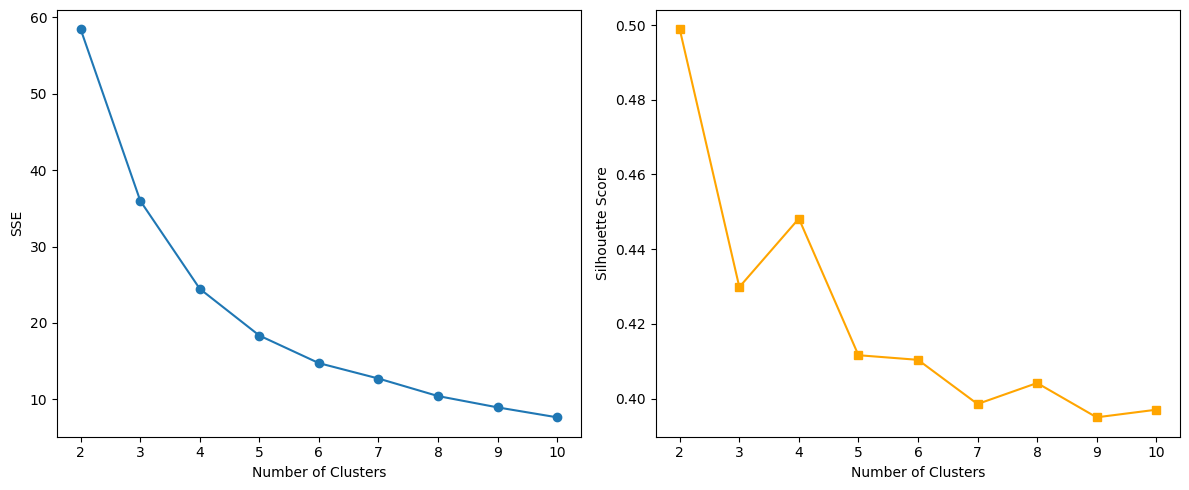

c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\1114975490.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rb['cluster'] = kmeans.fit_predict(features_scaled)


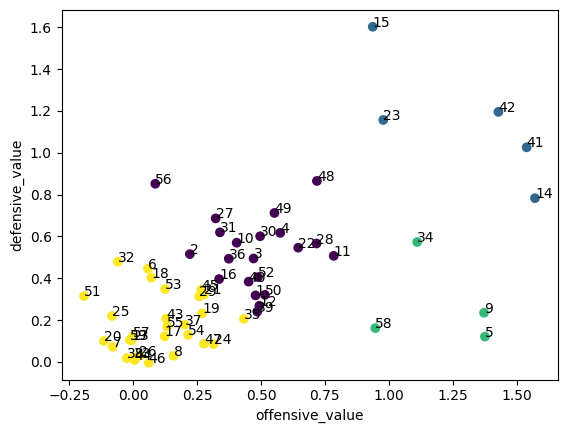

\begin{tabular}{rl}
\toprule
 Player Number &            Player Name \\
\midrule
             1 &                 Danilo \\
             2 &         Thomas Meunier \\
             3 &            Kyle Walker \\
             4 &        Kieran Trippier \\
             5 &        Youssouf Sabaly \\
             6 &           Hiroki Sakai \\
             7 &         DeAndre Yedlin \\
             8 & Trent Alexander-Arnold \\
             9 &      César Azpilicueta \\
            10 &             Dani Alves \\
            11 &             Matty Cash \\
            12 &         Connor Roberts \\
            13 &     Mohammed Al Burayk \\
            14 &         Ramin Rezaeian \\
            15 &          Achraf Hakimi \\
            16 &       Guillermo Varela \\
            17 &        Benjamin Pavard \\
            18 &    Bartosz Bereszyński \\
            19 &        Daniel Carvajal \\
            20 &             Shaq Moore \\
            21 &       Timothy Castagne \\
            22 &

C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\1114975490.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table_rb.to_latex(index=False)


In [33]:
features = rb[['offensive_value', 'defensive_value']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

cluster_range = range(2,11)
sse_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    rb['cluster'] = kmeans.fit_predict(features_scaled)

    sse = kmeans.inertia_
    sse_values.append(sse)

    silhouette_avg = silhouette_score(features_scaled, rb['cluster'])
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='s', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
rb['cluster'] = kmeans.fit_predict(features_scaled)

plt.scatter(rb['offensive_value'], rb['defensive_value'], c=rb['cluster'], cmap='viridis')
plt.xlabel('offensive_value')
plt.ylabel('defensive_value')

for i, txt in enumerate(range(len(rb))):
    plt.annotate(i+1, (rb['offensive_value'].iloc[i], rb['defensive_value'].iloc[i]))

plt.show()

table_data = {'Player Number': list(range(1, len(rb) + 1)),
              'Player Name': rb['player_name']}
table_rb = pd.DataFrame(table_data)
latex_table = table_rb.to_latex(index=False)
print(latex_table)

In [34]:
lb = playersRR[playersRR['position'] == 'LB']
sorted_lb = lb.sort_values('vaep_value', ascending=False)[:10]
sorted_lb

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team,position,value
225,6704.0,Theo Hernández,2.759760,1.756300,1.003460,653,France,LB,55000000
325,12034.0,David Raum,1.674913,0.423848,1.251065,350,Germany,LB,26000000
110,5209.0,Raphaël Guerreiro,1.665575,1.689791,-0.024215,336,Portugal,LB,20000000
496,32915.0,Ismail Jakobs,1.558386,0.700137,0.858248,266,Senegal,LB,7000000
111,5211.0,Jordi Alba,1.557370,0.795685,0.761685,680,Spain,LB,5000000
41,3382.0,Luke Shaw,1.549453,1.075564,0.473889,736,England,LB,28000000
91,4614.0,Antonee Robinson,1.429549,0.685053,0.744495,479,United States,LB,10000000
337,12625.0,Borna Sosa,1.307786,0.736996,0.570790,548,Croatia,LB,20000000
426,24085.0,Pervis Estupiñán,1.294438,0.669030,0.625408,361,Ecuador,LB,20000000
156,5544.0,Ricardo Rodríguez,1.132898,0.622388,0.510510,424,Switzerland,LB,3500000


In [35]:
correlation_coefficient, _ = pearsonr(lb['vaep_value'], lb['value'])
print(f'ピアソン相関係数: {correlation_coefficient}')

spearman_corr = lb[['vaep_value', 'value']].corr(method='spearman').iloc[0, 1]
print(f"スピアマンの順位相関係数: {spearman_corr}")

ピアソン相関係数: 0.28973323124810135
スピアマンの順位相関係数: 0.30361928376683084


c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\1787301771.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lb['cluster'] = kmeans.fit_predict(features_scaled)
c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X,

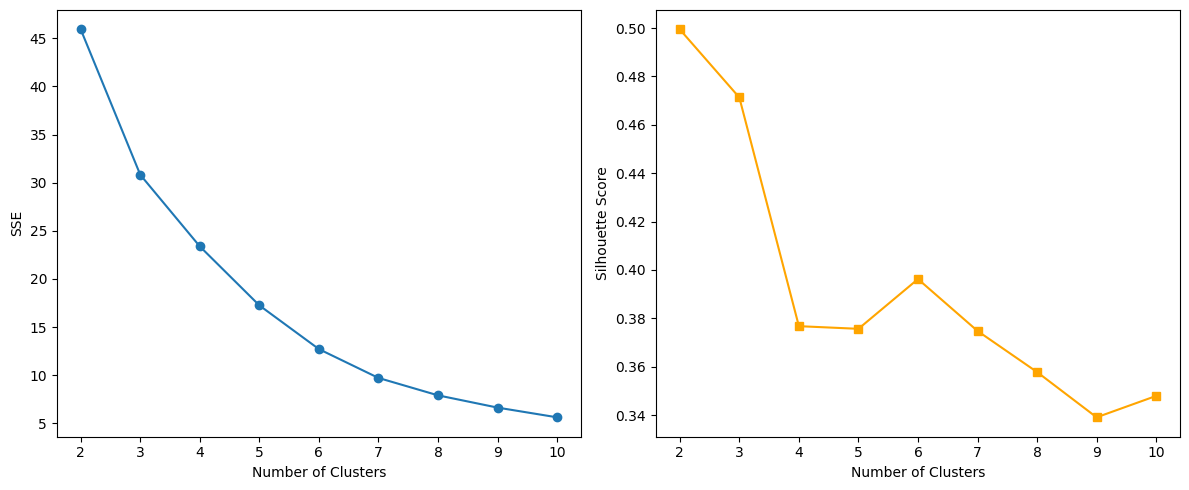

c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\1787301771.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lb['cluster'] = kmeans.fit_predict(features_scaled)


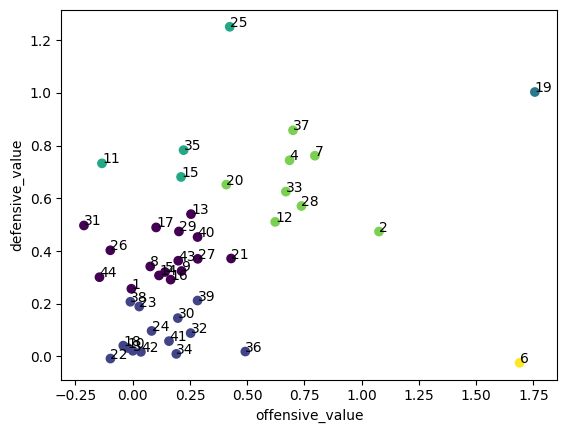

\begin{tabular}{rl}
\toprule
 Player Number &         Player Name \\
\midrule
             1 &          Ben Davies \\
             2 &           Luke Shaw \\
             3 &    Fodé Ballo Touré \\
             4 &    Antonee Robinson \\
             5 &   Yasir Al Shahrani \\
             6 &   Raphaël Guerreiro \\
             7 &          Jordi Alba \\
             8 &       Ehsan Hajsafi \\
             9 &         Aziz Behich \\
            10 &     Lucas Hernandez \\
            11 &  Nicolás Tagliafico \\
            12 &   Ricardo Rodríguez \\
            13 &      Jesús Gallardo \\
            14 &         Ali Maâloul \\
            15 &       Yuto Nagatomo \\
            16 &     Milad Mohammadi \\
            17 &        Bryan Oviedo \\
            18 &           Hong Chul \\
            19 &      Theo Hernández \\
            20 &         Alex Sandro \\
            21 &     Mathías Olivera \\
            22 &    Filip Mladenović \\
            23 &       Borna Barišić \\
  

C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\1787301771.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table_lb.to_latex(index=False)


In [36]:
features = lb[['offensive_value', 'defensive_value']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

cluster_range = range(2,11)
sse_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    lb['cluster'] = kmeans.fit_predict(features_scaled)

    sse = kmeans.inertia_
    sse_values.append(sse)

    silhouette_avg = silhouette_score(features_scaled, lb['cluster'])
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='s', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
lb['cluster'] = kmeans.fit_predict(features_scaled)

plt.scatter(lb['offensive_value'], lb['defensive_value'], c=lb['cluster'], cmap='viridis')
plt.xlabel('offensive_value')
plt.ylabel('defensive_value')

for i, txt in enumerate(range(len(lb))):
    plt.annotate(i+1, (lb['offensive_value'].iloc[i], lb['defensive_value'].iloc[i]))

plt.show()

table_data = {'Player Number': list(range(1, len(lb) + 1)),
              'Player Name': lb['player_name']}
table_lb = pd.DataFrame(table_data)
latex_table = table_lb.to_latex(index=False)
print(latex_table)

In [37]:
cb = playersRR[playersRR['position'] == 'CB']
sorted_cb = cb.sort_values('vaep_value', ascending=False)[:10]
sorted_cb

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,team,position,value
497,33018.0,Joško Gvardiol,3.687208,1.814456,1.872753,1030,Croatia,CB,60000000
193,5675.0,Kalidou Koulibaly,2.906705,1.630418,1.276287,404,Senegal,CB,35000000
177,5604.0,Kim Young-Gwon,2.285725,1.621156,0.664568,406,South Korea,CB,600000
384,20016.0,Pepe,2.223203,1.567375,0.655828,577,Portugal,CB,1000000
274,8519.0,Dayotchanculle Upamecano,2.219717,0.978762,1.240956,689,France,CB,50000000
32,3295.0,Thiago Silva,2.181818,0.886075,1.295743,644,Brazil,CB,2500000
481,30519.0,Mohamed Salisu,1.988989,1.233982,0.755007,293,Ghana,CB,18000000
38,3336.0,Harry Maguire,1.936417,0.760282,1.176136,796,England,CB,30000000
114,5219.0,Romain Saïss,1.912918,1.108892,0.804026,382,Morocco,CB,6500000
16,3090.0,Nicolás Otamendi,1.888505,0.920798,0.967707,1095,Argentina,CB,3000000


In [38]:
correlation_coefficient, _ = pearsonr(cb['vaep_value'], cb['value'])
print(f'ピアソン相関係数: {correlation_coefficient}')

spearman_corr = cb[['vaep_value', 'value']].corr(method='spearman').iloc[0, 1]
print(f"スピアマンの順位相関係数: {spearman_corr}")

ピアソン相関係数: 0.3616061424942403
スピアマンの順位相関係数: 0.3612221041166071


c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\1452989529.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cb['cluster'] = kmeans.fit_predict(features_scaled)
c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X,

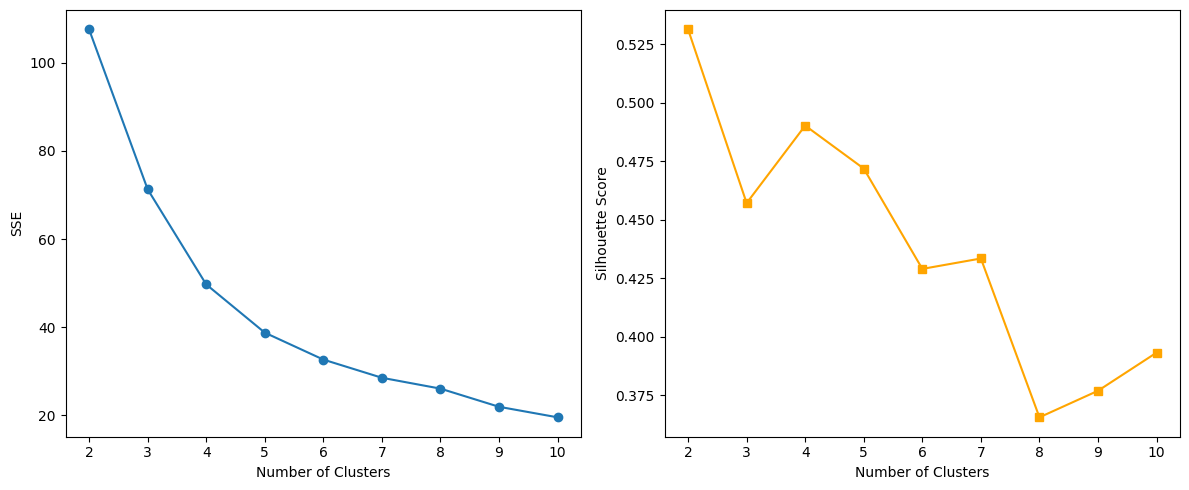

c:\Users\ryoya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\1452989529.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cb['cluster'] = kmeans.fit_predict(features_scaled)


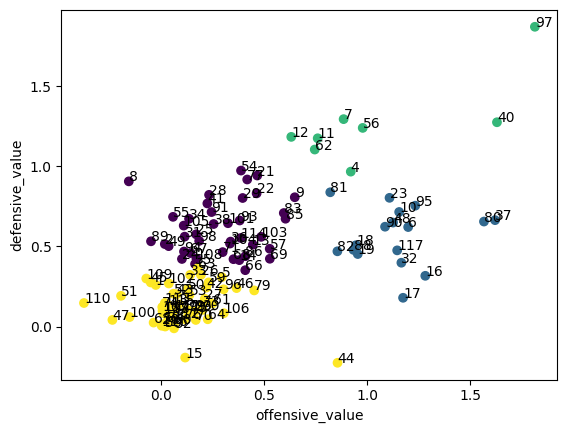

\begin{tabular}{rl}
\toprule
 Player Number &                     Player Name \\
\midrule
             1 &                 Alexander Djiku \\
             2 &                      Kamil Glik \\
             3 &                  Jan Vertonghen \\
             4 &                Nicolás Otamendi \\
             5 &                 Antonio Rüdiger \\
             6 &                     John Stones \\
             7 &                    Thiago Silva \\
             8 &                    Maya Yoshida \\
             9 &                      Nathan Aké \\
            10 &                     Daley Blind \\
            11 &                   Harry Maguire \\
            12 &                    Dejan Lovren \\
            13 &                 Virgil van Dijk \\
            14 &                  Daniel Amartey \\
            15 &             Edimilson Fernandes \\
            16 &             Andreas Christensen \\
            17 &                 Aymeric Laporte \\
            18 &          

C:\Users\ryoya\AppData\Local\Temp\ipykernel_15260\1452989529.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table_cb.to_latex(index=False)


In [39]:
features = cb[['offensive_value', 'defensive_value']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

cluster_range = range(2,11)
sse_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cb['cluster'] = kmeans.fit_predict(features_scaled)

    sse = kmeans.inertia_
    sse_values.append(sse)

    silhouette_avg = silhouette_score(features_scaled, cb['cluster'])
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='s', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cb['cluster'] = kmeans.fit_predict(features_scaled)

plt.scatter(cb['offensive_value'], cb['defensive_value'], c=cb['cluster'], cmap='viridis')
plt.xlabel('offensive_value')
plt.ylabel('defensive_value')

for i, txt in enumerate(range(len(cb))):
    plt.annotate(i+1, (cb['offensive_value'].iloc[i], cb['defensive_value'].iloc[i]))

plt.show()

table_data = {'Player Number': list(range(1, len(cb) + 1)),
              'Player Name': cb['player_name']}
table_cb = pd.DataFrame(table_data)
latex_table = table_cb.to_latex(index=False)
print(latex_table)

### (optional) inspect top 10 most valuable actions

2022-12-18 17:00:00 Argentina 3-3 France 48' interception Ángel Fabián Di María Hernández


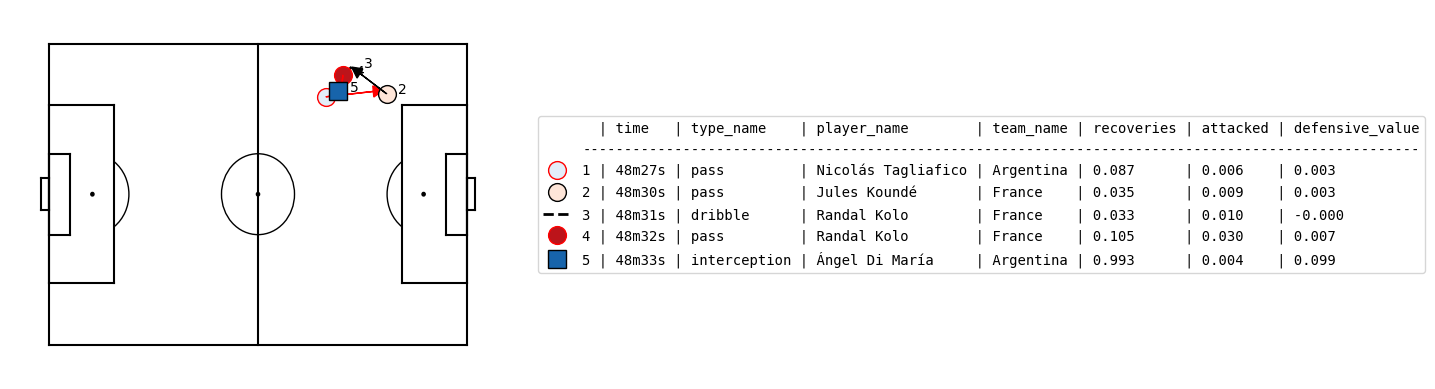

2022-12-18 17:00:00 Argentina 3-3 France 48' interception Nicolás Alejandro Tagliafico


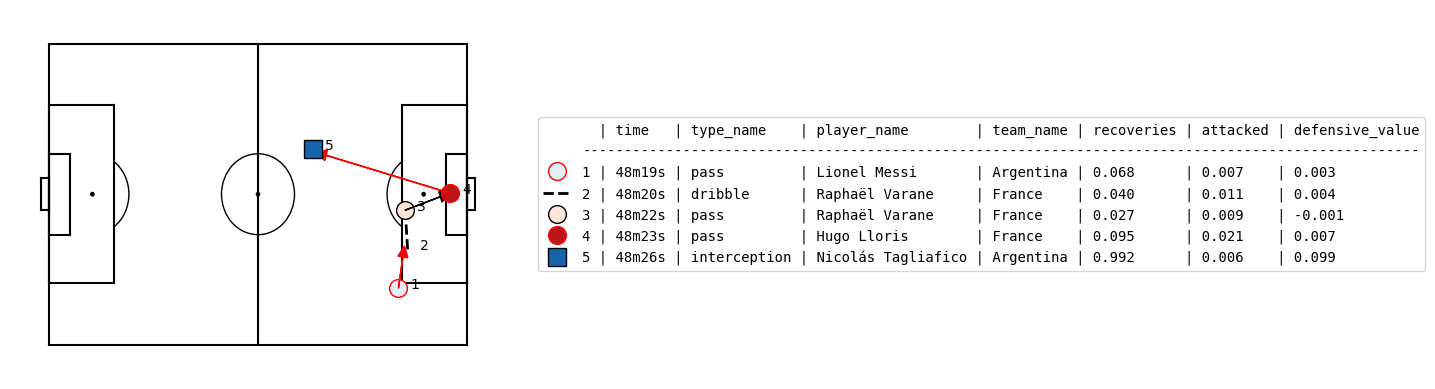

2022-12-13 21:00:00 Argentina 3-0 Croatia 48' tackle Alexis Mac Allister


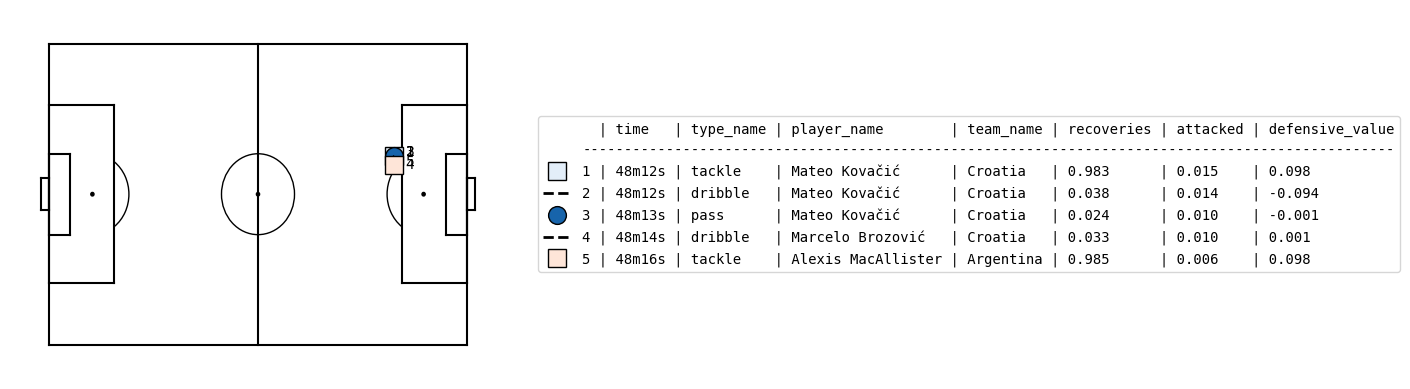

2022-12-09 21:00:00 Netherlands 2-2 Argentina 76' interception Nahuel Molina Lucero


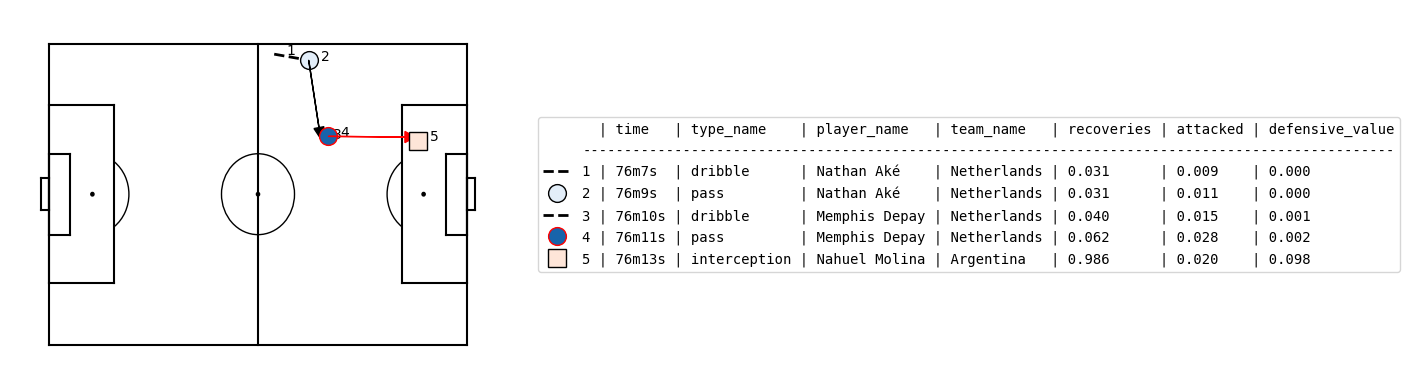

2022-12-03 21:00:00 Argentina 2-1 Australia 51' interception Alexis Mac Allister


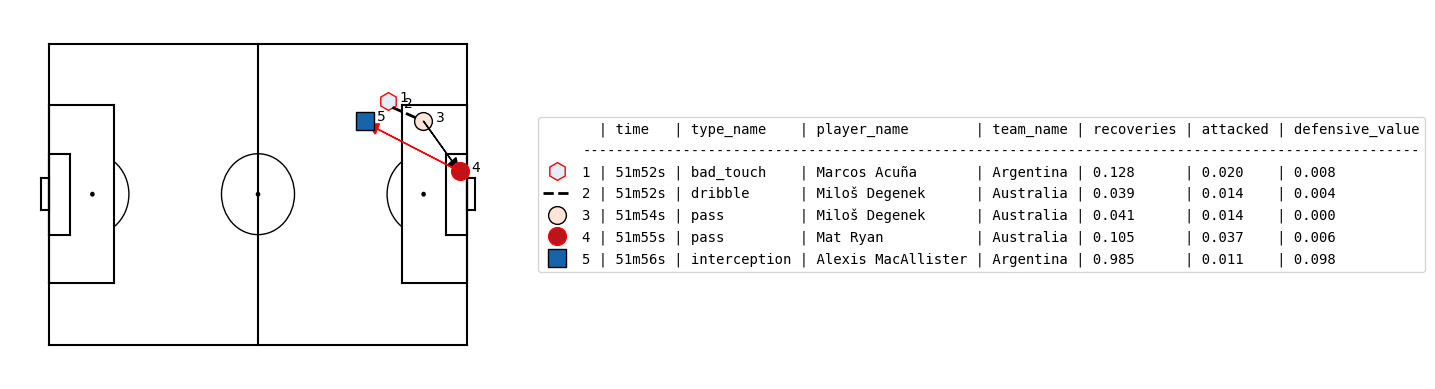

2022-12-18 17:00:00 Argentina 3-3 France 54' interception Rodrigo Javier De Paul


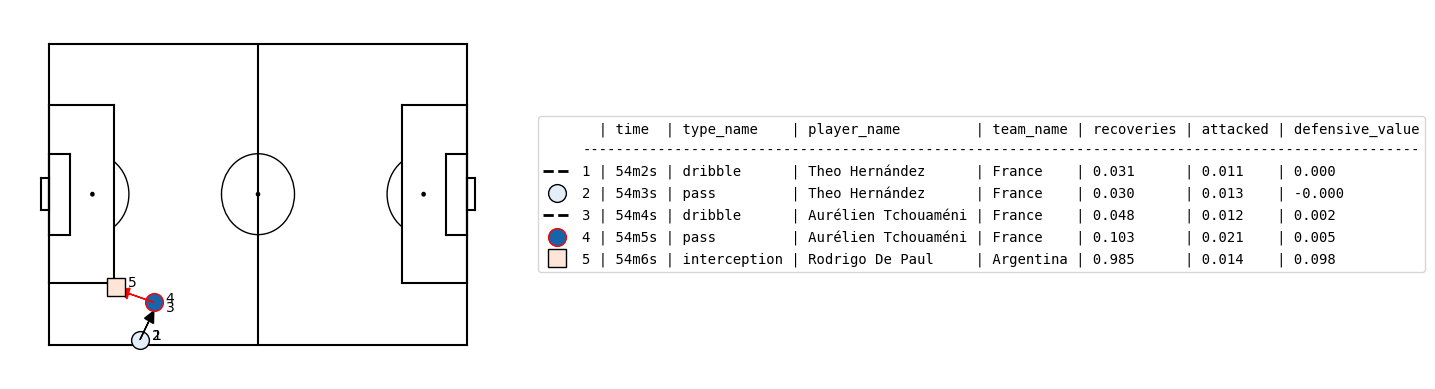

2022-12-09 21:00:00 Netherlands 2-2 Argentina 20' interception Nahuel Molina Lucero


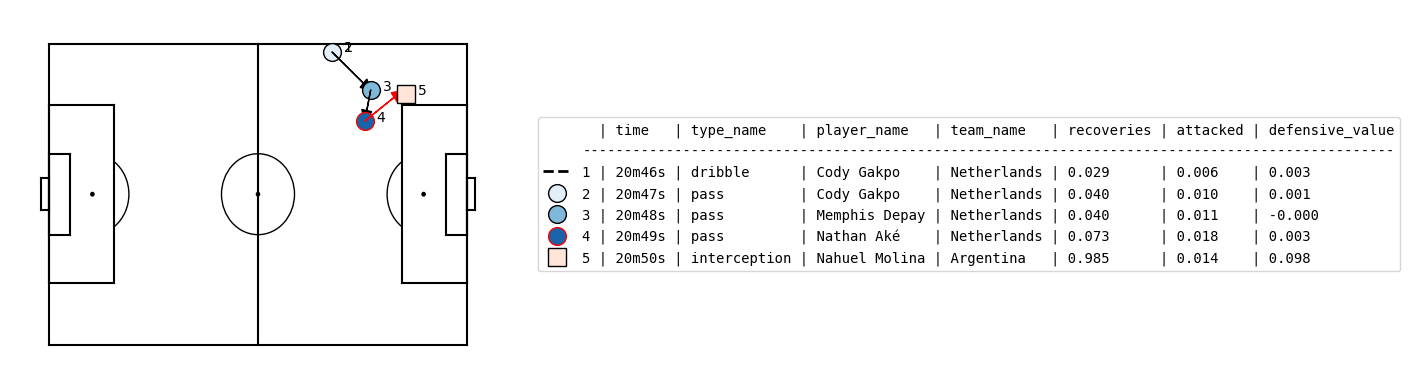

2022-11-30 21:00:00 Poland 0-2 Argentina 6' tackle Lionel Andrés Messi Cuccittini


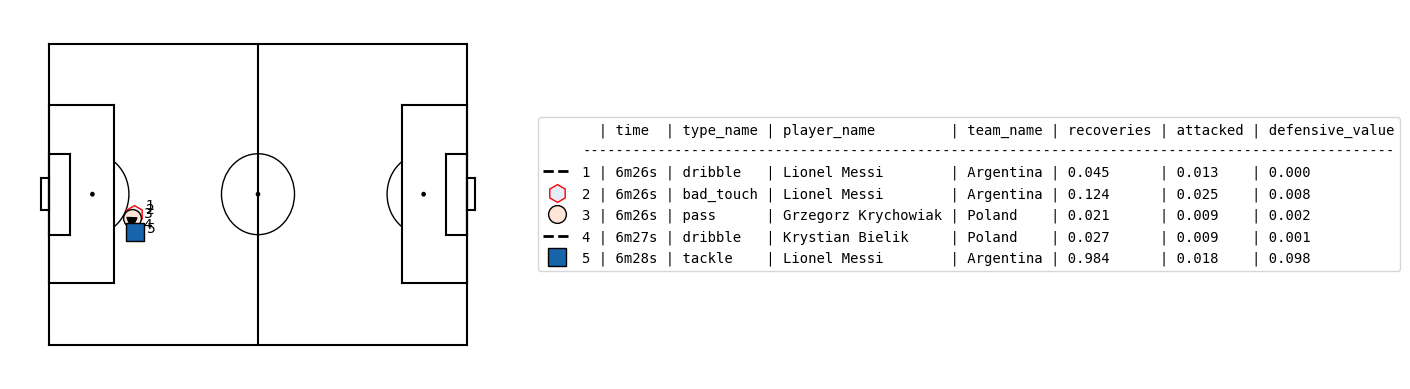

2022-11-22 12:00:00 Argentina 1-2 Saudi Arabia 44' interception Alejandro Darío Gómez


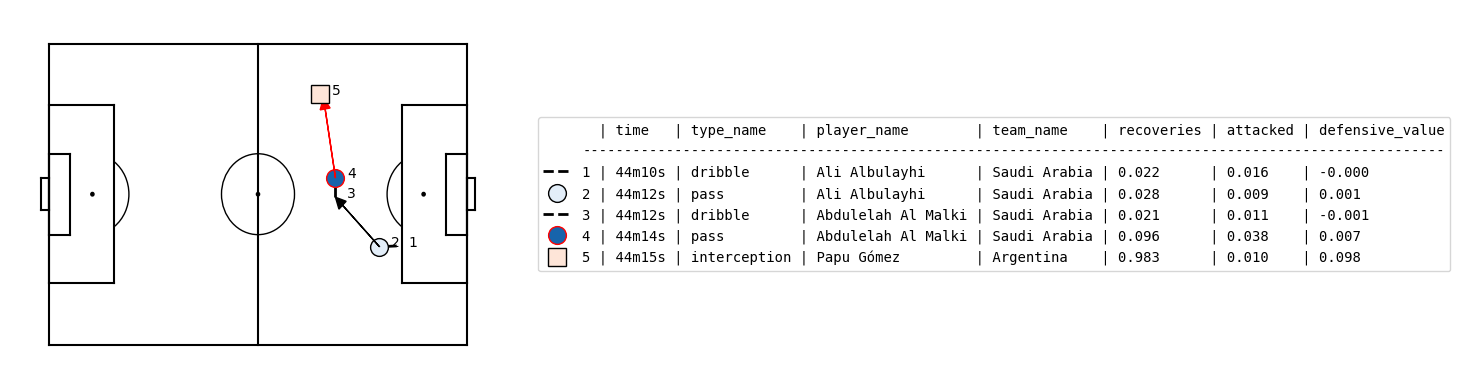

2022-12-03 21:00:00 Argentina 2-1 Australia 90' interception Rodrigo Javier De Paul


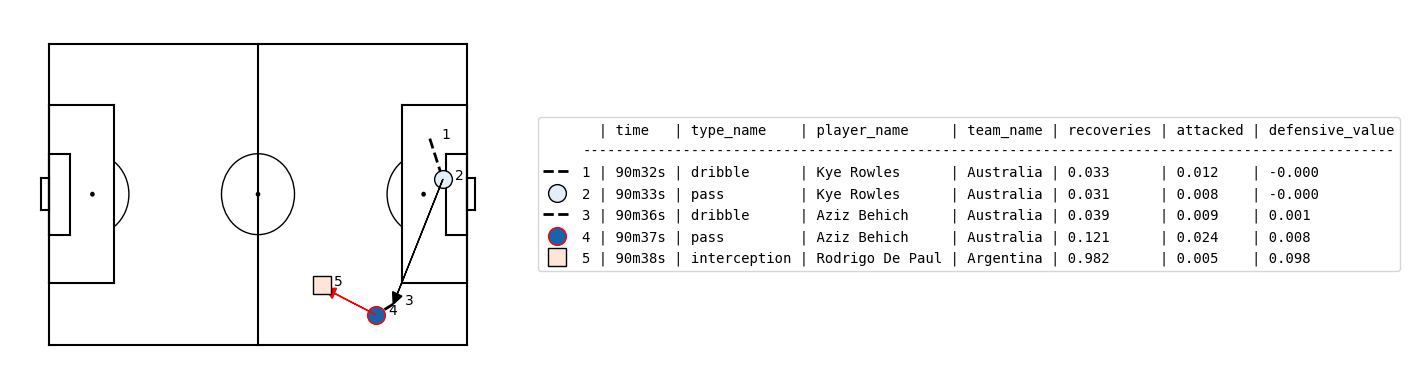

In [40]:
import matplotsoccer

sorted_A = A.sort_values("defensive_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Argentina"]
# sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")]

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0, 10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 4 : i+1].copy()
    
    a["player_name"] = a[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["recoveries"] = a.recoveries.apply(lambda x : "%.3f" % x )
    a["attacked"] = a.attacked.apply(lambda x : "%.3f" % x )
    a["defensive_value"] = a.defensive_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time", "type_name", "player_name", "team_name", "recoveries", "attacked", "defensive_value"]
    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=False)